In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/waste-classification-data


In [ ]:
import os

for dirname, _, filenames in os.walk(path):
    print(dirname)


/kaggle/input/waste-classification-data
/kaggle/input/waste-classification-data/DATASET
/kaggle/input/waste-classification-data/DATASET/TEST
/kaggle/input/waste-classification-data/DATASET/TEST/R
/kaggle/input/waste-classification-data/DATASET/TEST/O
/kaggle/input/waste-classification-data/DATASET/TRAIN
/kaggle/input/waste-classification-data/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/DATASET/TRAIN/O
/kaggle/input/waste-classification-data/dataset
/kaggle/input/waste-classification-data/dataset/DATASET
/kaggle/input/waste-classification-data/dataset/DATASET/TEST
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/R
/kaggle/input/waste-classification-data/dataset/DATASET/TEST/O
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/R
/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN/O


In [ ]:
train_path = path + "/DATASET/TRAIN"
test_path = path + "/DATASET/TEST"


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model  # also changed from vis_utils
from glob import glob


In [ ]:
x_data = []
y_data = []

from tqdm.notebook import tqdm  # For Colab progress bar

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*'), desc=f'Loading {category.split("/")[-1]}'):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_data.append(img)
        y_data.append(category.split("/")[-1])


Loading R:   0%|          | 0/9999 [00:00<?, ?it/s]

Loading O:   0%|          | 0/12565 [00:00<?, ?it/s]

In [ ]:
data = pd.DataFrame({
    'image': list(x_data),  # convert to list if it's a NumPy array
    'label': y_data
})

In [ ]:
data.shape

(22564, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

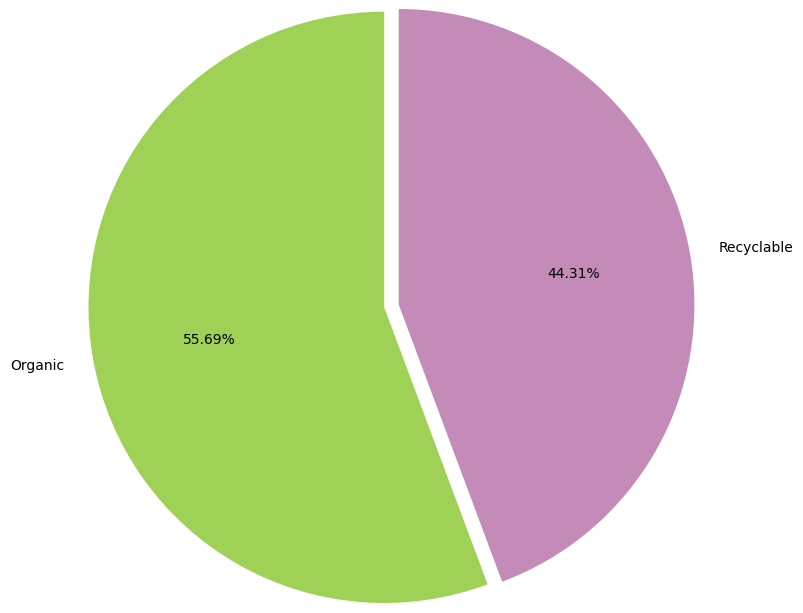

In [ ]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

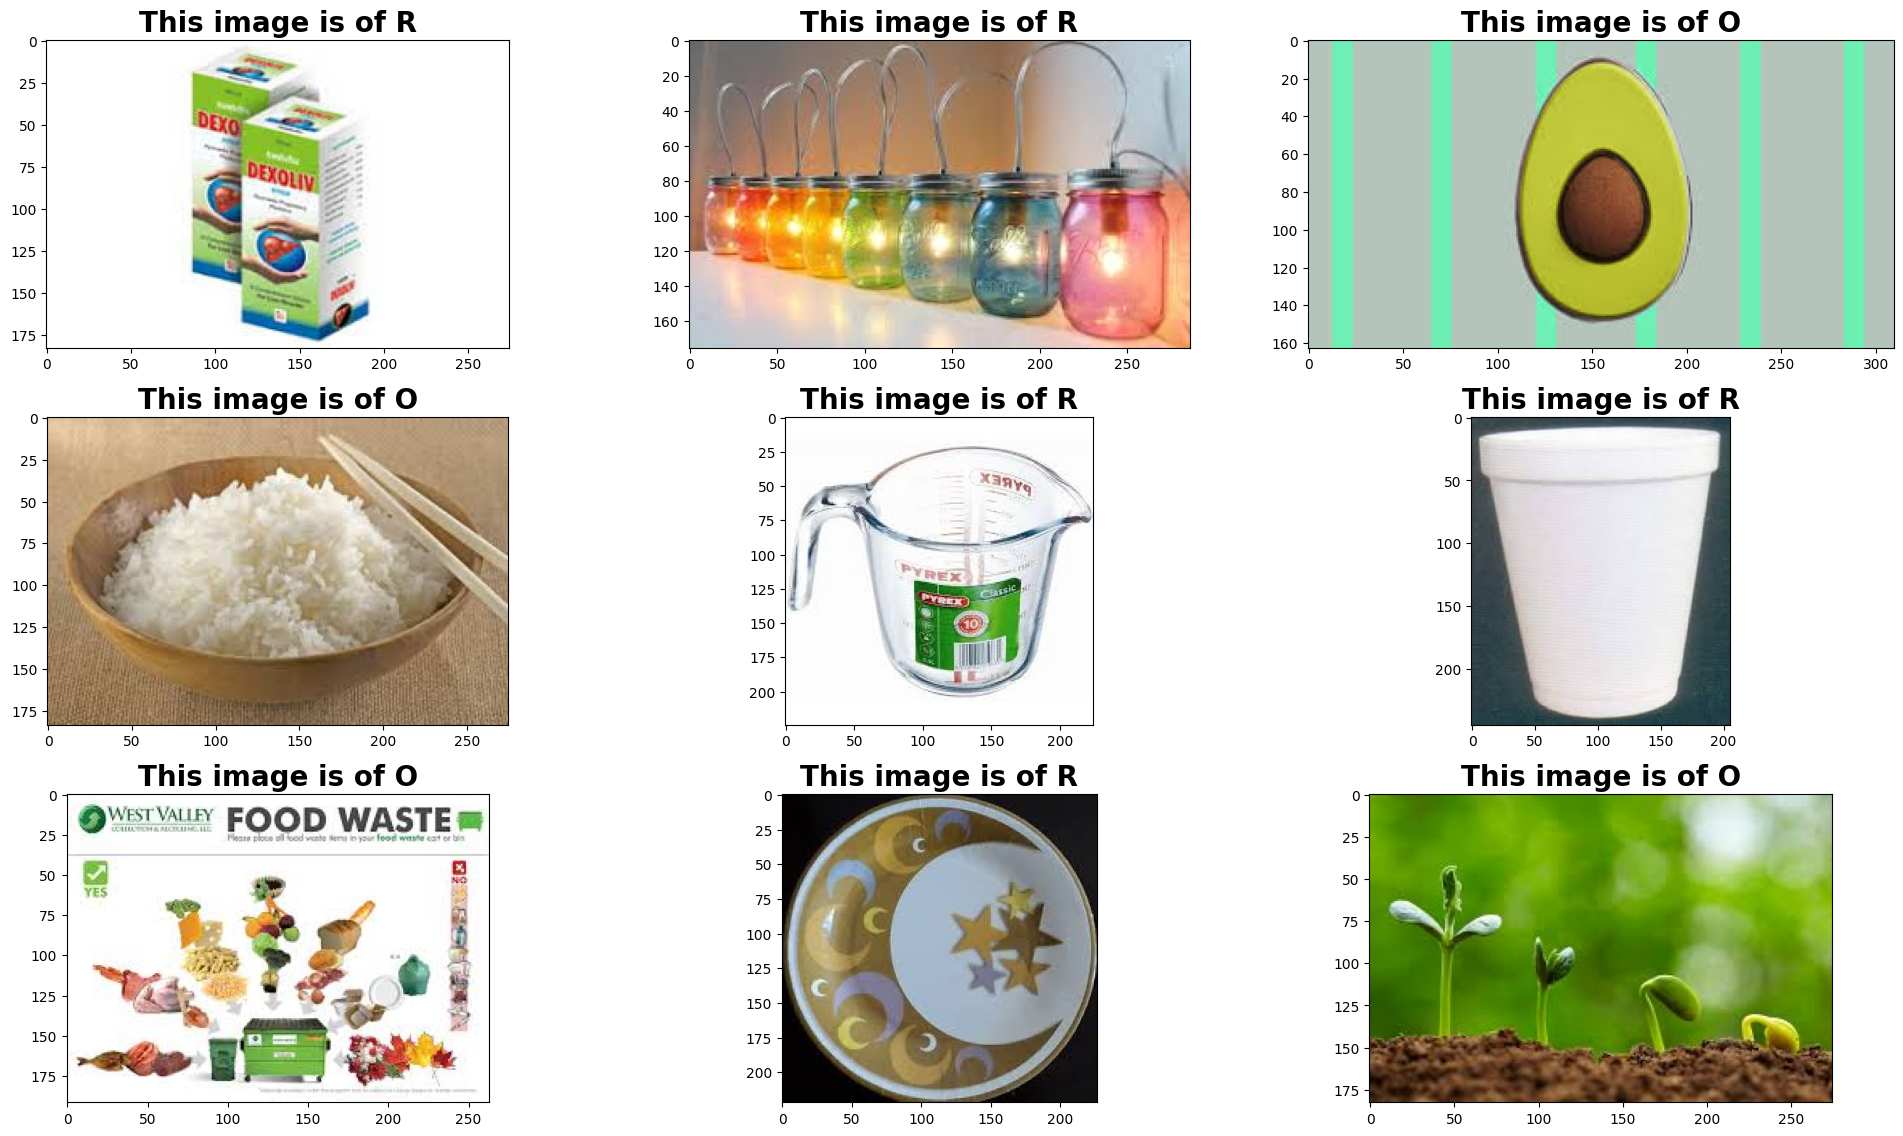

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

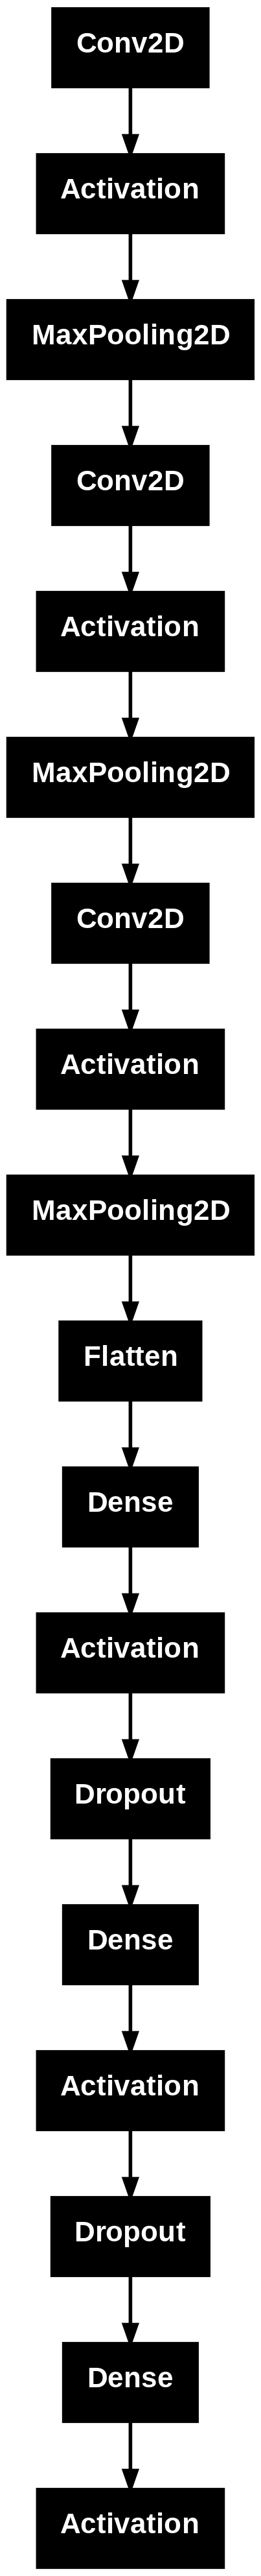

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
hist = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)


Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.7159 - loss: 0.6128 - val_accuracy: 0.8679 - val_loss: 0.3656
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 66s 741ms/step - accuracy: 0.8284 - loss: 0.4200 - val_accuracy: 0.8715 - val_loss: 0.3400
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 66s 751ms/step - accuracy: 0.8509 - loss: 0.3698 - val_accuracy: 0.8774 - val_loss: 0.2979
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 733ms/step - accuracy: 0.8664 - loss: 0.3423 - val_accuracy: 0.8472 - val_loss: 0.4059
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 70s 780ms/step - accuracy: 0.8633 - loss: 0.3423 - val_accuracy: 0.8918 - val_loss: 0.2650


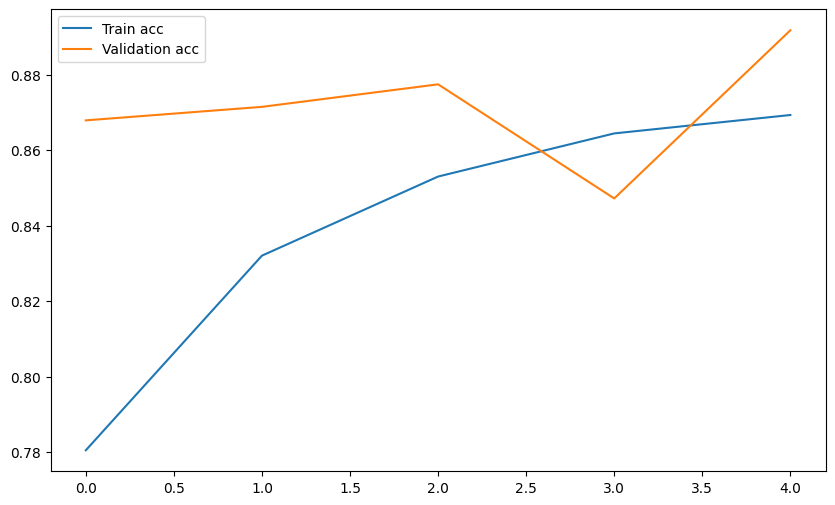

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

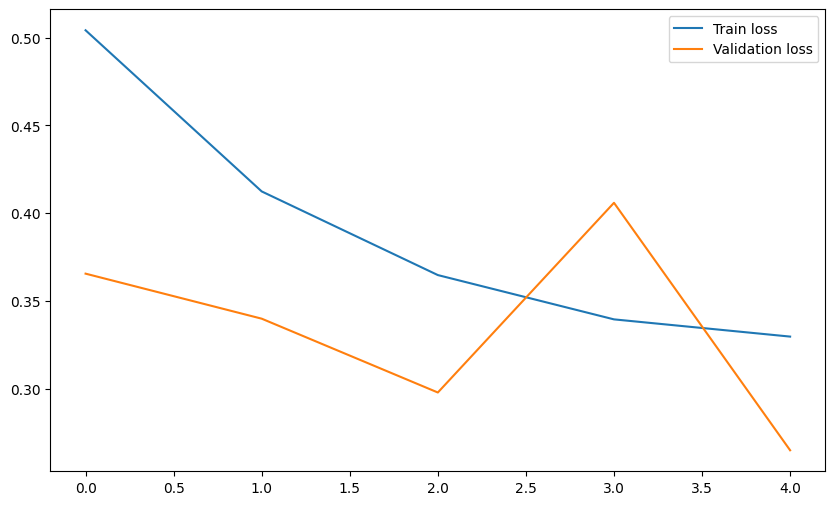

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
def predict_func(img):
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")

    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
This image -> Organic


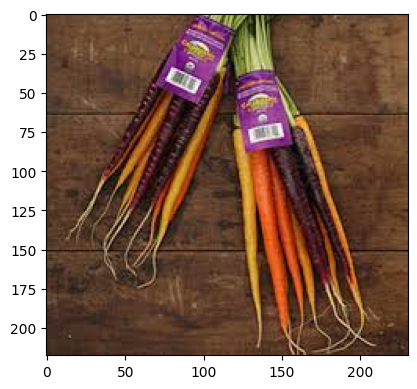

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12573.jpg")
predict_func(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
This image -> Recyclable


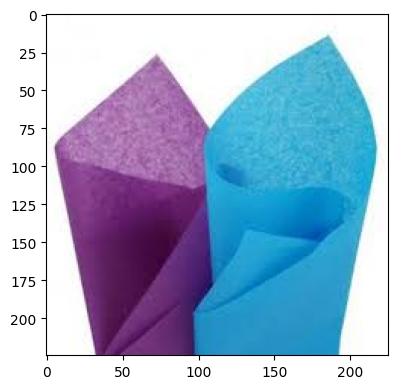

In [ ]:
test_img = cv2.imread("/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10753.jpg")
predict_func(test_img)

In [ ]:
model.save('waste_classifier_model.keras')
